In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister,ClassicalRegister
from IPython.display import clear_output
import matplotlib.pyplot as plt
import qiskit.quantum_info as qi
from qiskit.circuit import ParameterVector
import time 
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2,RealAmplitudes
import numpy as np

import pickle 
import time
from qiskit.circuit.library import iSwapGate
from math import comb

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator


In [2]:
J=1
n_qubits=53
sqrt_iSWAP = iSwapGate().power(1/2)

from matplotlib import colormaps
list(colormaps)
cmap = 'gist_heat'

f = 0.2
nSteps = 10
precision = 0.01


#We place the charge at the center of the system initially.
# Matter defect records the initial position of the charge.
# InitialKey is the bitstring of the initial state. It consists of 53 qubits of alternating sites and links
# For sites, 1 means that there is no charge. And the site at the center has 0 so that a charge it put in there. 
matter_defect=[27]
initial_charge = 26
#initialKey = getInitialKey(matter_defect)
initialKey = '10101010101010101010101010001010101010101010101010101'
nn = np.array([int(numeric_string) for numeric_string in initialKey]) 
dtFactor=0.4 #Picking larger time step so that shorter circuits are used to surpress noise.
initial_charge_position = n_qubits-matter_defect[0] #Reversing the order because the label of qubtis and the bitstring is in reverse
nShots = 100000 

Trotter_time = np.arange(1*dtFactor,14*dtFactor,dtFactor) #13 steps in total. Ignoring the trivial initial state.
nTrotter_total = Trotter_time.shape[0]

#Calculating the number of steps needed to reach the final time.
#Each simulated step is in intervals of 0.4. 
#In reality, we allow the circuit time to be as large as 0.6 such that the circuit could be shorter.
# But no larger than 0.6 to ensure accuracy. Also making sure each step has the same size.
dt_min = 0.6
nTrotter_list = np.ceil(Trotter_time/dt_min) #Use the ceiling to determine the minimum number of steps
dt_list = Trotter_time/nTrotter_list


def getChargeArr(evs):
    p_list = []
    for i in range(evs.shape[0]):
        if i%2==0:
            p=1-evs[i]
            p_list.append(p)
    return np.array(p_list)
            

In [3]:
# The following function reproduces the circuit shown in  https://arxiv.org/abs/2203.08905
# the add3Q function builds the 3Q block in Figure 1.c of the paper above
# getTrotterCircuit then uses this function to build the full Trotter circuit
def add3Q(circuit,tmpIndex,alpha=J):
    tmpIndex1=(tmpIndex+1)%(n_qubits)
    tmpIndex2=(tmpIndex+2)%(n_qubits)
    
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    #circuit.barrier()
    circuit.rz(np.pi,tmpIndex)
    circuit.rz(-np.pi/4,tmpIndex1)
    circuit.rz(-np.pi/4,tmpIndex2)
    circuit.append(sqrt_iSWAP, [tmpIndex1, tmpIndex2])
    
    circuit.rz(np.pi-alpha,tmpIndex1)
    circuit.rz(alpha,tmpIndex2)
    circuit.append(sqrt_iSWAP, [tmpIndex1, tmpIndex2])
    circuit.rz(np.pi/4,tmpIndex1)
    circuit.rz(np.pi/4,tmpIndex2)
    #circuit.barrier()
            
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    
    
def getTrotterCircuit(n_qubits,J,nTrotter=2,fFactor=0.2,dtFactor=0.2,matter_defect=[11],measure=True,rescale=False,parity_trotter = 0):

    f=fFactor*J
    dt_mag=dtFactor/J
    
    circuit = QuantumCircuit(n_qubits)
    #circuit = QuantumCircuit(n_qubits,n_qubits)
    
    #First produce the initial state:
    for i in range(n_qubits):
        defect_flag=False

        for index in matter_defect:
            if i== index - 1:
                defect_flag=True

        if defect_flag==False:
            if i%2!=0:
                circuit.h(i)
                
            else:
                circuit.x(i)
 
    #Trotterization:
    for step in range(nTrotter):
        if rescale:
            
            if step < int(nTrotter/2):
            
                dt = dt_mag
            else: 
                dt = -dt_mag
            #print(step, nTrotter,dt,step <= int(nTrotter/2))
        else:
            dt = dt_mag
        circuit.barrier()
        
        n_end=0# no period
        
        if parity_trotter == 0:
            for i in range(int(n_qubits/4)):
                tmpIndex=i*4
                add3Q(circuit,tmpIndex,alpha=J*dt)
            circuit.barrier()

            
            for i in range(int(n_qubits/4)-n_end):
                tmpIndex=i*4+2
                add3Q(circuit,tmpIndex,alpha=J*dt)
            circuit.barrier()
            
        elif parity_trotter ==1:
            
            for i in range(int(n_qubits/4)-n_end):
                tmpIndex=i*4+2
                add3Q(circuit,tmpIndex,alpha=J*dt)
            circuit.barrier()
            
            for i in range(int(n_qubits/4)):
                tmpIndex=i*4
                add3Q(circuit,tmpIndex,alpha=J*dt)
            circuit.barrier()


        parity_trotter = (parity_trotter+1)%2
        
        for i in range(int(n_qubits/2)):
            tmpIndex=i*2
            circuit.rz(0,tmpIndex)
            circuit.rx(f*dt,tmpIndex+1)
        #Adding last rotation gate if it is an odd number
        if tmpIndex+1 == n_qubits-2:
            circuit.rz(0,tmpIndex+2)
        
    for i in range(n_qubits):
        if i%2 ==1:
            circuit.h(i)
    
    if measure:
        circuit.measure_all()
    return circuit
    
  


In [4]:
circuit = getTrotterCircuit(n_qubits,J,nTrotter=1,fFactor=f,dtFactor=0.6,matter_defect=matter_defect,rescale=False)

depth =  22
312 CNOT
depth =  41
624 CNOT
depth =  60
936 CNOT
depth =  79
1248 CNOT
depth =  98
1560 CNOT
depth =  117
1872 CNOT
depth =  136
2184 CNOT
depth =  155
2496 CNOT
depth =  174
2808 CNOT
depth =  193
3120 CNOT
depth =  212
3432 CNOT
depth =  231
3744 CNOT
depth =  250
4056 CNOT


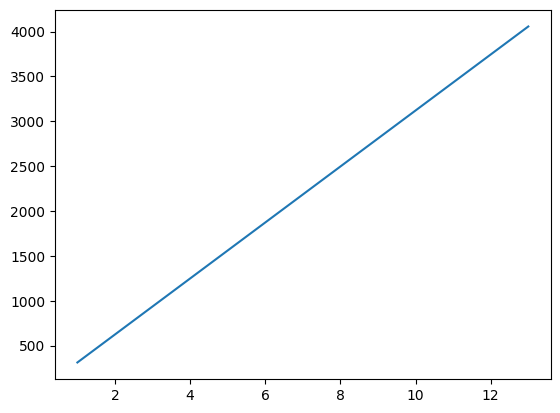

In [7]:
#checking the depth and total number of CNOT gates
nTotal = 14
depth = []
nCNOT = []
for nTrotter in range(nTotal-1):
    circuit = getTrotterCircuit(n_qubits,J,nTrotter=nTrotter+1,fFactor=f,dtFactor=0.6,matter_defect=matter_defect,rescale=False)
    depth.append(circuit.depth())
    nCNOT.append(circuit.count_ops()['xx_plus_yy']*2)
    print("depth = ",circuit.depth())
    print(circuit.count_ops()['xx_plus_yy']*2, "CNOT")
    
plt.plot(np.arange(1,14,1),nCNOT)

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
# Save an IBM Quantum account and set it as your default account.

service = QiskitRuntimeService(channel="ibm_quantum",instance="ibm-q-utokyo/internal/icepp-r5",token="")
QiskitRuntimeService.save_account(channel="ibm_quantum",overwrite=True,instance="ibm-q-utokyo/internal/icepp-r5", token="", set_as_default=True)

#service = QiskitRuntimeService()

service.backends()
backend = service.backend("ibm_torino")
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
backend.status()


In [ ]:
n_jobs = nTrotter_list*5+5 # sending more jobs for longer circuits, anticipating a larger uncertainty for those
print(nTrotter_list,n_jobs)
print("total number of Jobs:",sum(n_jobs))

jobs_dict = {}

#Sending the jobs to IBM Quantum. For each Trotter step, send the precomputed nunmber of jobs
#Have a jagged array to record the job IDs.
with Session(backend=backend) as session:
    sampler_em = Sampler(mode = session)
    sampler_em.options.dynamical_decoupling.enable = True
    #sampler_em.options.dynamical_decoupling.sequence_type = "XY4"
    sampler_em.options.twirling.enable_gates = True
    #sampler_em.options.resilience.measure_mitigation = True

    for i in range(len(nTrotter_list)):
        nTrotter = int(nTrotter_list[i])
        
        dt = dt_list[i]
        print("current trotter size = ", nTrotter," dt = ", dt, 't_total = ', dt*nTrotter," matter_defect = ",matter_defect)

        jobs_id_list = []
        for j in np.arange(0,n_jobs[i],1):
            circuit = getTrotterCircuit(n_qubits,J,nTrotter=nTrotter,fFactor=f,dtFactor=dt,matter_defect=matter_defect,rescale=False)
            isa_qc = pm.run(circuit)
            job = sampler_em.run([(isa_qc,[])],shots = nShots)

            print(f"job ID: {job.job_id()}")
            jobs_id_list.append(job.job_id())
            
        key = "nTrotter_"+str(nTrotter)+"_evo_"+str(dt)
        jobs_dict[key] =  jobs_id_list


total number of Jobs: 405.0
current trotter size =  1  dt =  0.4 t_total =  0.4  matter_defect =  [27]


/Users/lizhelun/miniforge3/envs/qiskit2/lib/python3.11/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:875: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


job ID: d23e5r7daq30008vamag
job ID: d23e5t7zpxt000884bm0
job ID: d23e5w7cnfn00080cpxg
job ID: d23e5xzdaq30008vamb0
job ID: d23e5zfzpxt000884bmg
job ID: d23e618cnfn00080cpyg
job ID: d23e630mxja0008sfa4g
job ID: d23e64rzpxt000884bn0
job ID: d23e668daq30008vamc0
job ID: d23e681fqqn0008kh8s0
current trotter size =  2  dt =  0.4 t_total =  0.8  matter_defect =  [27]
job ID: d23e69sam1xg00895dx0
job ID: d23e6b9zpxt000884bng
job ID: d23e6d1cnfn00080cpzg
job ID: d23e6esmxja0008sfa60
job ID: d23e6gjzpxt000884bp0
job ID: d23e6jaam1xg00895dxg
job ID: d23e6m2daq30008vamcg
job ID: d23e6njmxja0008sfa6g
job ID: d23e6qjam1xg00895dy0
job ID: d23e6s3cnfn00080cq0g
job ID: d23e6tvdaq30008vamdg
job ID: d23e6wkfqqn0008kh8t0
job ID: d23e6ybmxja0008sfa70
job ID: d23e6zvdaq30008vame0
job ID: d23e71mcnfn00080cq1g
current trotter size =  3  dt =  0.4000000000000001 t_total =  1.2000000000000002  matter_defect =  [27]
job ID: d23e73czpxt000884bpg
job ID: d23e754mxja0008sfa80
job ID: d23e76wcnfn00080cq20
job ID: 

job ID: d23emt3daq30008vanag
job ID: d23emvvfqqn0008kh9r0
job ID: d23emxkmxja0008sfb2g
job ID: d23emzbam1xg00895ewg
job ID: d23en0wzpxt000884cr0
current trotter size =  8  dt =  0.55 t_total =  4.4  matter_defect =  [27]
job ID: d23en2mdaq30008vanb0
job ID: d23en4cam1xg00895ex0
job ID: d23en64cnfn00080cr10
job ID: d23en85fqqn0008kh9sg
job ID: d23en9xzpxt000884crg
job ID: d23enbndaq30008vanc0
job ID: d23enddcnfn00080cr1g
job ID: d23enexcnfn00080cr20
job ID: d23engymxja0008sfb30
job ID: d23enjpam1xg00895exg
job ID: d23enm6daq30008vand0
job ID: d23ennyzpxt000884cs0
job ID: d23enqpfqqn0008kh9tg
job ID: d23ensfzpxt000884csg
job ID: d23env7mxja0008sfb40
job ID: d23enwzmxja0008sfb4g
job ID: d23enyqfqqn0008kh9v0
job ID: d23ep08zpxt000884ct0
job ID: d23ep20zpxt000884ctg
job ID: d23ep3rfqqn0008kh9w0
job ID: d23ep5gcnfn00080cr30
job ID: d23ep78am1xg00895ez0
job ID: d23ep91fqqn0008kh9wg
job ID: d23epahzpxt000884cv0
job ID: d23epcham1xg00895ezg
job ID: d23epe1daq30008vane0
job ID: d23epfsdaq30008va

In [ ]:
# Saving the bitstring information
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')
evo_name = "Torino_"+str(n_qubits)+"RealTimeEvo_"+datetime.today().strftime('%Y-%m-%d')

print(evo_name)
with open(evo_name+'.pkl', 'wb') as file:
    pickle.dump(jobs_dict, file)

Torino_53RealTimeEvo_2025-07-28


In [ ]:
def getStringList(jobs_dict,exception_list = []):
    # Looping through jobs for all Trotter steps.
    #Retrieve information and save accordingly.
    string_list_dict = {}
    for key in jobs_dict.keys():
        print(key)
        l = jobs_dict[key]
        string_list = []
        for job_id in l:
            print(job_id)
            if job_id in exception_list:
                continue
            job = service.job(job_id)
            r = job.result()
            string = r[0].data.meas.get_counts()
            string_list.append(string)
        string_list_dict[key] = string_list
    return string_list_dict

In [18]:
string_list_evo = getStringList(jobs_dict)

nTrotter_1_evo_0.4
d23e5r7daq30008vamag
d23e5t7zpxt000884bm0
d23e5w7cnfn00080cpxg
d23e5xzdaq30008vamb0
d23e5zfzpxt000884bmg
d23e618cnfn00080cpyg
d23e630mxja0008sfa4g
d23e64rzpxt000884bn0
d23e668daq30008vamc0
d23e681fqqn0008kh8s0
nTrotter_2_evo_0.4
d23e69sam1xg00895dx0
d23e6b9zpxt000884bng
d23e6d1cnfn00080cpzg
d23e6esmxja0008sfa60
d23e6gjzpxt000884bp0
d23e6jaam1xg00895dxg
d23e6m2daq30008vamcg
d23e6njmxja0008sfa6g
d23e6qjam1xg00895dy0
d23e6s3cnfn00080cq0g
d23e6tvdaq30008vamdg
d23e6wkfqqn0008kh8t0
d23e6ybmxja0008sfa70
d23e6zvdaq30008vame0
d23e71mcnfn00080cq1g
nTrotter_3_evo_0.4000000000000001
d23e73czpxt000884bpg
d23e754mxja0008sfa80
d23e76wcnfn00080cq20
d23e78ddaq30008vameg
d23e7a5zpxt000884bq0
d23e7bxcnfn00080cq2g
d23e7ddzpxt000884bqg
d23e7f5am1xg00895dzg
d23e7gycnfn00080cq30
d23e7jpdaq30008vamf0
d23e7m6zpxt000884br0
d23e7nyfqqn0008kh8w0
d23e7qemxja0008sfa90
d23e7s7am1xg00895e00
d23e7tzzpxt000884brg
d23e7wqfqqn0008kh8wg
d23e7yfam1xg00895e0g
d23e800fqqn0008kh8x0
d23e81gcnfn00080cq40
d23e

d23evddcnfn00080cre0
d23evf5daq30008vansg
d23evgyam1xg00895fb0
d23evjpzpxt000884da0
d23evmemxja0008sfbeg
d23evp6mxja0008sfbfg
d23evrfcnfn00080creg
d23evt7mxja0008sfbg0
d23evw7cnfn00080crf0
d23evxzam1xg00895fc0
d23evzzfqqn0008kha90
d23ew1gfqqn0008kha9g
d23ew38daq30008vant0
d23ew50zpxt000884db0
d23ew6ram1xg00895fcg
d23ew8hfqqn0008khaag
d23ewa9zpxt000884dbg
d23ewc1zpxt000884dc0
d23ewdsam1xg00895fd0
d23ewfhfqqn0008khab0
d23ewhaam1xg00895fdg
d23ewk2mxja0008sfbhg
d23ewmtzpxt000884ddg
d23ewpjam1xg00895fe0
d23ewrbdaq30008vantg
d23ewt3cnfn00080crg0
d23ewvvdaq30008vanv0
d23ewxkam1xg00895ff0
d23ewzbdaq30008vanvg
d23ex14zpxt000884de0
d23ex2wam1xg00895ffg


In [ ]:
# Saving the bitstrings as pkl files
with open("Torino_53RealTimeEvo_2025-07-28_strings.pkl", 'wb') as file:
    pickle.dump(string_list_evo, file)

In [23]:
import qiskit
print(qiskit.__version__
     )

2.0.0


In [ ]:
#Some obsolete function:

# # Here are various functions that help us analyze the charge dynamics
# # From the simulator, we retrieve a collection of bitstring as measurement outcomes.
# # Our aim is to analyze the charge dynamics from these outcomes.
# def checkZ2Charge(key):
#     # This function takes a bitstring key and returns the charge information.
#     # One key notice: the charge output tracks the number of 1s in the bitstring by summing the values
#     # However, the number of charges is defined as the number of 0s.
#     # the real "charge number" should be nsites - charge.
    
#     charge = []
#     firstCharge_pos = 0
#     for i in np.arange(0,len(key),1): # Assuming first and last are matter site.
#         #assuming matter sites are all even
#         #it is backward!
#         if i%2 == 0:
#             charge.append(int(key[i]))
#             if int(key[i]) == 0:
#                 firstCharge_pos = i 
#     charge = np.array(charge)
    
#     return charge.sum(),firstCharge_pos,charge 

# def getEVs(string,initialKey = initialKey,charge_conservation = True,gauge = True):
#     out = np.zeros(n_qubits)
#     shots = 0
    
#     n_charge = []
    
#     for key in list(string.keys()):
#         charge, charge_position,charge_arr = checkZ2Charge(key)
#         for j in range(string[key]):
#             n_charge.append(charge - initial_charge)
    
#         if gauge:
#             tmpKey = np.array([int(numeric_string) for numeric_string in initialKey])  
#             if charge_position == initial_charge_position:
#                 tmpKey = tmpKey #do nothing

#             else:

#                 tmpKey[initial_charge_position] = 1
#                 tmpKey[charge_position] = 0
#                 #then flip the links

#                 if charge_position > initial_charge_position:
#                     for pos in np.arange(initial_charge_position+1,charge_position,1):
#                         if pos%2 ==1: #flip link
#                             tmpKey[pos] = 1

#                 else:
#                     for pos in np.arange(charge_position+1, initial_charge_position,1):

#                         if pos%2 ==1: #flip link
#                             tmpKey[pos] = 1
                            
#         else:
#             tmpKey = np.array([int(numeric_string) for numeric_string in key])  
                  
  
#         arr = 1 -2*tmpKey #|0> to have eigenValue of 1, and |1> to have -1.
        
#         for i in range(arr.shape[0]): #introduce a negative sign for all the matter site
#             if i%2==0:
#                 arr[i] = -arr[i]
        

#         out += arr*string[key]
#         shots += string[key]
#     output = out/shots
    
#     return (output+1)/2, np.array(n_charge)


# def getStringList(jobs_dict):
#     string_list_dict = {}

#     for key in jobs_dict.keys():
#         print(key)
#         l = jobs_dict[key]
#         string_list = []
#         for job_id in l:
#             print(job_id)
#             job = service.job(job_id)
#             r = job.result()
#             string = r[0].data.meas.get_counts()
#             string_list.append(string)
#         string_list_dict[key] = string_list
#     return string_list_dict

# def getEVs_fromString(string_list_dict,charge_conservation = True,gauge = True):
#     evs_list_dict = {}
#     prob_list_dict = {}
#     for key in string_list_dict.keys():
#         print(key)
#         evs_list_tmp = []
#         l = string_list_dict[key]
#         for string in l:
#             evs= getEVs(string,charge_conservation = charge_conservation, gauge = gauge)[0]
#             evs_list_tmp.append(evs)

#         evs_list_tmp=np.array(evs_list_tmp).mean(axis=0)
#         evs_list_dict[key] = evs_list_tmp
#         prob_list_dict[key] = getChargeArr(evs_list_tmp)
#     return evs_list_dict, prob_list_dict
